# The initial condition for global mean surface temperature is quite different than JRA55. Why is this?

In [2]:
import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import dask
dask.config.set(**{"array.slicing.split_large_chunks": False})

In [3]:
from src.utils import utils

In [4]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [5]:
xr.set_options(keep_attrs=True)

# Cluster

In [12]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 12
memory = "48GB"
cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

In [13]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.48.69:8787/status,
Dashboard: http://10.6.48.69:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.48.69:32917,Workers: 0
Dashboard: http://10.6.48.69:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Open some data

In [60]:
data_dir = "/g/data/xv83/dcfp/CAFE-f6"
realm = "atmos_isobaric_month.zarr.zip"
variable = "t_ref"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-????11??/{realm}"))


def preprocess_CAFEf6_monthly(ds):
    """Preprocessing steps for CAFE-f6 data"""
    ds = utils.round_to_start_of_month(ds, dim="time")
    ds = utils.convert_time_to_lead(ds)

    # Keep every 12th month
    ds = ds.sel(lead=slice(0, 120, 12))

    # Truncate lats so that forecasts run on different systems can be stacked
    ds = utils.truncate_latitudes(ds)

    return ds


f6_atmos_hcst = (
    xr.open_mfdataset(
        files,
        compat="override",
        preprocess=preprocess_CAFEf6_monthly,
        engine="zarr",
        coords="minimal",
        parallel=True,
    )[variable]
    .mean("ensemble")
    .compute()
)

cafe_atmos_area = f6_atmos_hcst["area"]

In [61]:
jra = utils.truncate_latitudes(
    xr.open_zarr(
        "/g/data/xv83/reanalyses/JRA55/surface_month_cafe-grid.zarr.zip",
        use_cftime=True,
    )
)["TMP_GDS0_HTGL"]

jra = jra.rename({"initial_time0_hours": "time"})
# Force to Julian calendar
jra = jra.assign_coords(
    {
        "time": xr.cftime_range(
            start=jra.time[0].item().strftime(),
            end=jra.time[-1].item().strftime(),
            freq="MS",
            calendar="julian",
        )
    }
)

jra = jra.where(jra.time.dt.month == 11, drop=True).compute()

# Demonstrate the issue

In [62]:
def global_mean(ds, area):
    sl = {"lat": slice(-90, 90)}
    return ds.sel(sl).weighted(area).mean(["lat", "lon"])


f6_atmos_gbl = global_mean(f6_atmos_hcst, cafe_atmos_area)
jra_gbl = global_mean(jra, cafe_atmos_area)

(-14610.0, 11688.0)

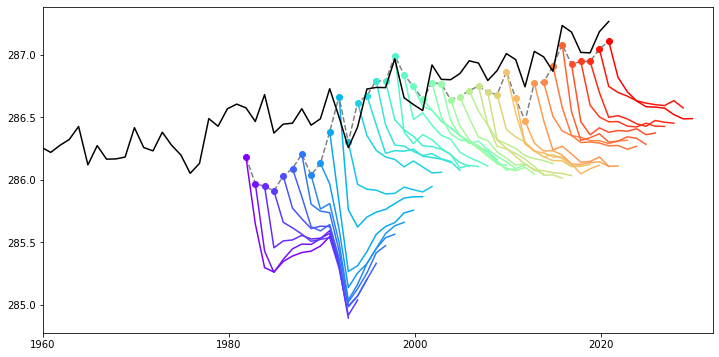

In [63]:
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(12, 6))

color = cm.rainbow(np.linspace(0, 1, len(f6_atmos_gbl.init)))
for i, c in zip(f6_atmos_gbl.init, color):
    hcst = f6_atmos_gbl.sel(init=i)
    plt.plot(hcst.time[0], hcst[0], color=c, marker="o")
    plt.plot(hcst.time, hcst, color=c)

plt.plot(
    f6_atmos_gbl.isel(lead=0).time,
    f6_atmos_gbl.isel(lead=0),
    color="grey",
    linestyle="--",
    zorder=-1,
)
plt.plot(jra_gbl.time, jra_gbl, color="black")
plt.xlim(cftime.DatetimeJulian(1960, 1, 1), cftime.DatetimeJulian(2032, 1, 1))

Text(0.5, 1.0, 'Difference')

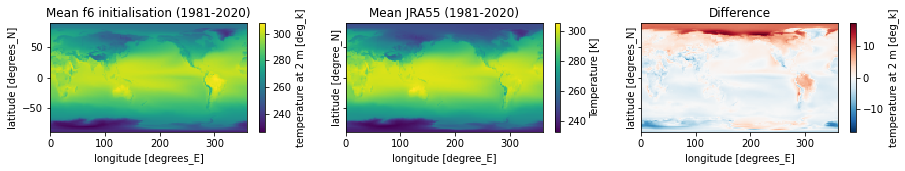

In [64]:
f6_init_mean = f6_atmos_hcst.isel(lead=0).mean("init")

jra_mean = jra.sel(time=f6_atmos_hcst.isel(lead=0).time).mean("init")

diff = f6_init_mean - jra_mean

fig = plt.figure(figsize=(15, 2))
axs = fig.subplots(1, 3, sharey=True)

f6_init_mean.plot(ax=axs[0])
axs[0].set_title("Mean f6 initialisation (1981-2020)")
jra_mean.plot(ax=axs[1])
axs[1].set_title("Mean JRA55 (1981-2020)")
diff.plot(ax=axs[2])
axs[2].set_title("Difference")

# There is no issue, you were just originally comparing `t_surf` to 2m temperature...

In [65]:
cluster.close()
client.close()